In [7]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%autoreload 2  
%matplotlib inline

This notebook demonstrates the fitting of a 2D Gaussian random field

In [9]:
from __future__ import print_function
import numpy as np 
import matplotlib.pyplot as plt
import sys
sys.path.append("../")
import triangle
import george
from IPython.html.widgets import interact
from george.kernels import ExpSquaredKernel

In [10]:
import sample_and_fit_gp as sam
import diag_plots as dplot

In [11]:
np.random.seed(1)  # fix the random seed for reproducibility

In [12]:
truth = [1.5, .5]  # right now uses George's parametrization
data_pt_nos = 10
rng = (0, 100.)
noise_amp = 1e-1

parametrization of the Sq Exp kernel in George is: 
\begin{equation}
k(r_{ij}) = \lambda^{-1} \exp\left(\frac{\beta r_{ij}^2 }{ 2.}\right)
\end{equation}

Our parametrization has the restriction of:


In [13]:
coords, psi, psi_err = \
    sam.generate_2D_data(truth, data_pt_nos, ExpSquaredKernel, 
                         rng, noise_amp)

TypeError: 'type' object is not iterable

check that our drawn data points are not crazy

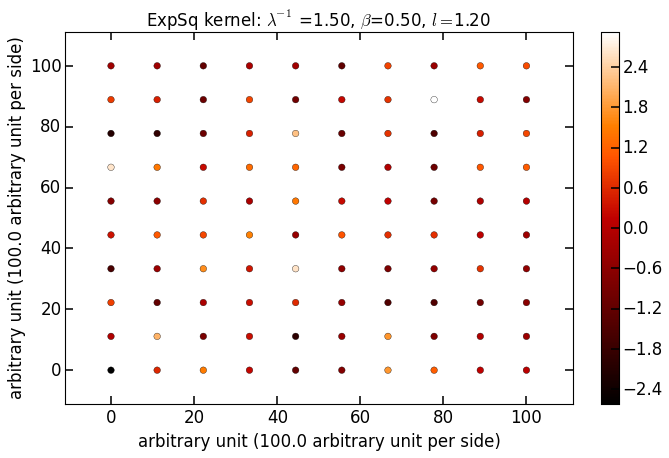

In [9]:
dplot.plot_2D_gp_samples(psi, coords, figside=6, 
                         truth=truth, range_No=rng[1],
                         kernel_name="ExpSq")

# set prior in log scale!!! very important

In [10]:
lnHP_truth = list(np.log(truth[:2])) + truth[2:]
print(lnHP_truth)

[0.40546510810816438, -0.69314718055994529]


try to initialize a broad prior 

In [59]:
lnprior_vals = np.array([[-1, 2], [-1, 1.]])

In [60]:
data = (coords, psi, psi_err)

make sure that I didn't put in unreasonable prior 

In [13]:
assert sam.lnprior_gp(truth, 
                      lnprior_vals=lnprior_vals) is not -np.inf,\
    "invalid prior choice"

# test how initial locations of the chains affect the results

In [14]:
# the proposal scale parameter a = 2.0 by default, I have hard tuned this 
# so the acceptance fraction 0.2 < a_f < 0.5
# maybe tuning a wszis not the best thing to do

In [61]:
sam.lnprob_gp(np.log(truth), ExpSquaredKernel,
               coords, psi, psi_err)

-151.79711855072026

In [62]:
sampler, p0 = \
    sam.fit_gp(lnHP_truth, ExpSquaredKernel, data, guess_dev_frac=1e-1, 
               lnprior_vals=lnprior_vals, nwalkers=8, a=3.5, 
               burnin_chain_len=0, conver_chain_len=1e4)  

Initial guesses were [ 1.63054233  0.49775422]
Initial guesses were [ 1.40496082  0.46850701]
Initial guesses were [ 1.51199146  0.49093001]
Initial guesses were [ 1.46153287  0.52136929]
Initial guesses were [ 1.44679863  0.48405873]
Initial guesses were [ 1.51893298  0.49977245]
Initial guesses were [ 1.51816566  0.4812902 ]
Initial guesses were [ 1.44647195  0.55816924]
Running production chain with length 10000.0
the optimized p0 values are 
[[ 1.01401701  0.65010247]
 [ 1.13368846  0.71910609]
 [ 1.03321027  1.37139607]
 [ 1.31662241  1.95600312]
 [ 1.20172702  0.83332133]
 [ 1.31148063  0.77080262]
 [ 1.29158009  0.5676387 ]
 [ 1.27201388  1.30793552]]


# plot properties

In [63]:
labels = [r"$\ln\,\lambda^{-1}$", r"$\ln\, \beta$"]

# visualize the trace plots

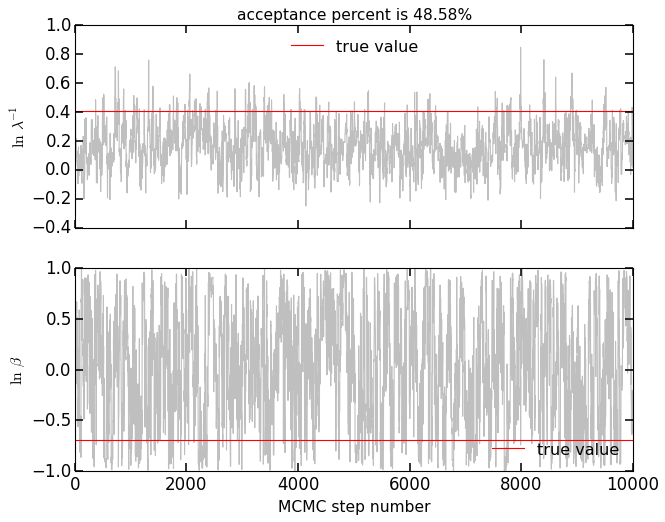

In [64]:
dplot.trace_plot(sampler, labels, np.log(truth))

-[x] burn in seems adequate   
-[x] chains seem to have converged  

# visualize the 68% and 95% credible contours 

N_bins = 50
N_bins = 50


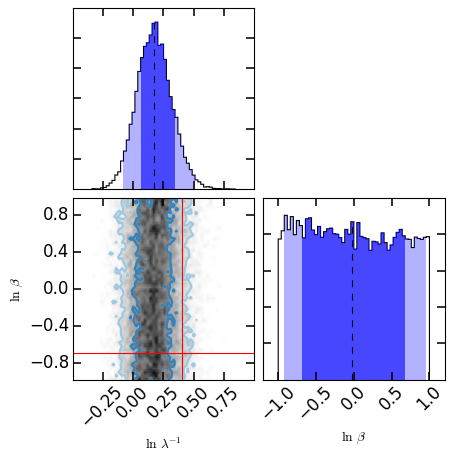

In [65]:
est = dplot.N_by_N_lower_triangle_plot(
        sampler.flatchain.transpose(), 0.05, [0, 1], 
        truth=np.log(truth),  # have to be aware of if we take log or not 
        axlabels=labels, xlabel_to_rot=[45, 45],
        N_bins=[50, 50])

# plot likelihood surface

# Compute likelihood of fit using George 

In [20]:
samples = sampler.flatchain
ix = [np.random.randint(len(samples)) for i in range(10)]
for i in range(10):
    hp = np.exp(samples[ix[i]])

# Project data points and show fit 

draw random samples in the chains and compute the fit 

In [21]:
samples = sampler.flatchain  # still in log space 

In [22]:
np.log(truth)

array([ 0.40546511, -0.69314718])

In [23]:
lnprior_vals

array([[-5.,  5.],
       [-5.,  5.]])

# make use of the built in function for checking performance 

lnlikelihood of the true value 

In [24]:
gp = george.GP(truth[0] * 
               ExpSquaredKernel(truth[1], ndim=2))
gp.compute(coords, psi_err)
gp.lnlikelihood(psi)

-151.79711855072026

In [25]:
truth

[1.5, 0.5]

Ok the chains do seem to be stopped at a place with lower likelihood 

# try using the true params to compute the marginal likelihood instead 

In [27]:
truth

[1.5, 0.5]

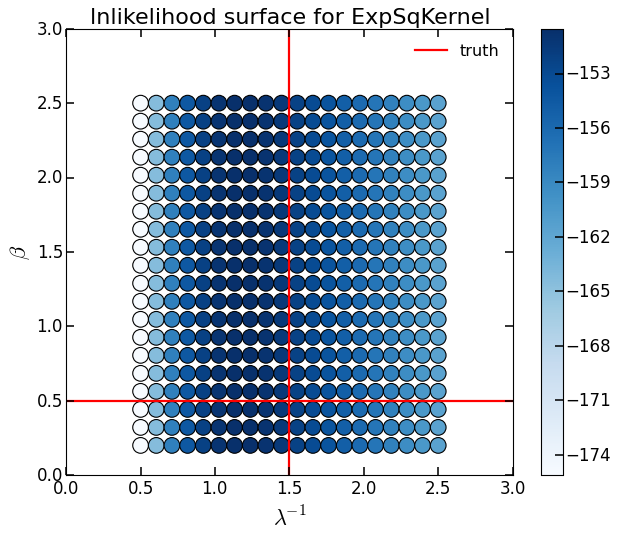

In [88]:
params = np.array([[p1, p2] 
          for p1 in np.linspace(truth[0] - 1., truth[0] + 1., 20)
          for p2 in np.linspace(truth[1] - .3, truth[1] + 2, 20)])

likelihood_surface =[]
for p in params:
    # print(p)
    gp = george.GP(p[0] * ExpSquaredKernel(p[1], ndim=2))
    gp.compute(coords, psi_err)
    likelihood_surface.append(gp.lnlikelihood(psi))

plt.scatter(params[:, 0], params[:, 1], c=likelihood_surface, s=200)
plt.axvline(truth[0], color='r', lw=2, label='truth')
plt.axhline(truth[1], color='r', lw=2)
plt.colorbar()
plt.title("lnlikelihood surface for ExpSqKernel")
plt.xlabel(r"$\lambda^{-1}$")
plt.ylabel(r"$\beta$")
plt.legend()

# try a bunch of ridiculous parameter values 

In [75]:
rid = [(10, 100), (1000, 50), (0.1, 0.2), (.3, 10)]
for hp in rid: 
    gp = george.GP(hp[0] * ExpSquaredKernel(hp[1], ndim=2))
    gp.compute(coords, psi_err)
    print("hp = " + 
          "({1}, {2}) lnlikelihood of fit is {0}".format(
                gp.lnlikelihood(psi), *hp))

hp = (10, 100) lnlikelihood of fit is -213.832363327
hp = (1000, 50) lnlikelihood of fit is -428.785010103
hp = (0.1, 0.2) lnlikelihood of fit is -540.884293191
hp = (0.3, 10) lnlikelihood of fit is -226.571251483


NameError: global name 'spacing' is not defined

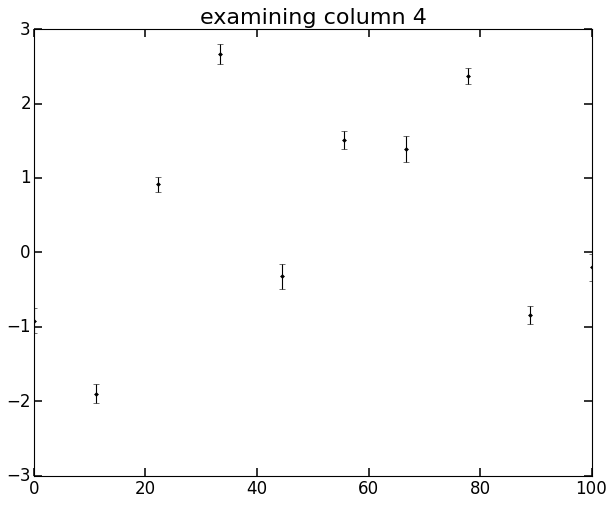

In [50]:
interact(change_x_ix, x_ix=(0, data_pt_nos, 1))

In [ ]:
interact(change_y_ix, y_ix=(0, int(rng[1] / spacing - 1), 1))